# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_octubre_2018/conjunto_entrenamiento_octubre_2018_red_pitch5mm_rad161mm_total.mat')
conjunto_datos= datos_matlab.get('photodefA')
conjunto_datos.shape

(66498, 640)

In [3]:
import os
import pandas as pd
dir_name='../datos_octubre_2018'
base_filename='p_OF_5mm_161mm'
filename_suffix='.h5'
file=os.path.join(dir_name, base_filename+ "{0:03d}".format(0) + filename_suffix)
conjunto_datos_waves=pd.read_hdf(file,'MC')
datos_waves=conjunto_datos_waves.values
datos_waves.shape

(6320, 3840)

In [4]:
for i in range(1,2):
    file=os.path.join(dir_name, base_filename+ "{0:03d}".format(i) + filename_suffix)
    #print(file)
    veamos=pd.read_hdf(file,'MC')
    veamos_array=veamos.values
    datos_waves=np.concatenate((datos_waves,veamos_array),axis=0)
datos_waves.shape

(12641, 3840)

In [5]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
# input image dimensions
img_rows, img_cols = 16, 40

X_trained=datos_waves;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;

print(x_trained.shape)


(12641, 3840)


In [6]:
input_output_dim_A=img_rows*img_cols
ideaA=np.zeros((L1A,input_output_dim_A))

conjunto_datos=np.zeros((x_trained.shape[0]*L1A,input_output_dim_A))
for i in range(x_trained.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_trained[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    conjunto_datos[(i)*L1A :(i+1)*L1A,:] = ideaA    
    

  

## Network parameters:

In [7]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dim = 320  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_img = Input(shape=(img_rows*img_cols,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(img_cols*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encoded)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoder = Model(input_img, decoded)

## Prepare data into training and test set.

In [8]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]





Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

75846
conjunto_datos shape: (75846, 640)
45507
15169
15170


In [9]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)


input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [10]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (45507, 40, 16, 1)
45507 train samples
15169 validation samples
15170 test samples


Display 20 random training images using image

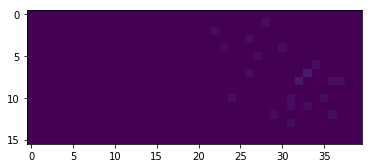

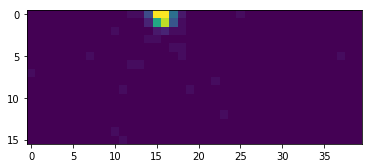

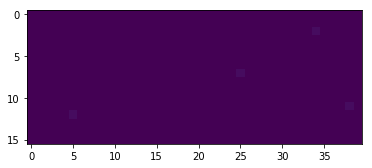

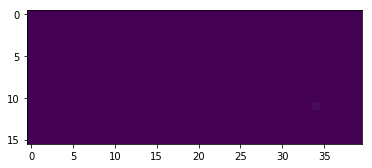

In [11]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 40]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()

Vamos a generar las matrices de datos para la red neuronal 

In [12]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(45507, 640)
(15170, 640)


## Build the autoencoder. 

In [13]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])



Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [14]:
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/{}".format(time()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto', baseline=None)
autoencoder.fit(x_train, x_train,
                epochs=5000,
                batch_size=500,
                shuffle=False,
                callbacks=[tensorboard, early_stop],
                validation_data=(x_test, x_test))



Train on 45507 samples, validate on 15170 samples
Epoch 1/5000
45507/45507 [==============================] - 1s 25us/step - loss: 3.3293 - mean_absolute_error: 0.1943 - val_loss: 2.7150 - val_mean_absolute_error: 0.2179
Epoch 2/5000
45507/45507 [==============================] - 1s 20us/step - loss: 3.0468 - mean_absolute_error: 0.1700 - val_loss: 2.6057 - val_mean_absolute_error: 0.2007
Epoch 3/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.9662 - mean_absolute_error: 0.1666 - val_loss: 2.5462 - val_mean_absolute_error: 0.1900
Epoch 4/5000
45507/45507 [==============================] - 1s 19us/step - loss: 2.9128 - mean_absolute_error: 0.1653 - val_loss: 2.5039 - val_mean_absolute_error: 0.1850
Epoch 5/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.8708 - mean_absolute_error: 0.1646 - val_loss: 2.4703 - val_mean_absolute_error: 0.1828
Epoch 6/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.8358 - mean_

45507/45507 [==============================] - 1s 20us/step - loss: 2.3001 - mean_absolute_error: 0.1701 - val_loss: 2.0544 - val_mean_absolute_error: 0.1611
Epoch 49/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.2928 - mean_absolute_error: 0.1698 - val_loss: 2.0468 - val_mean_absolute_error: 0.1625
Epoch 50/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.2857 - mean_absolute_error: 0.1701 - val_loss: 2.0437 - val_mean_absolute_error: 0.1634
Epoch 51/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.2793 - mean_absolute_error: 0.1706 - val_loss: 2.0444 - val_mean_absolute_error: 0.1671
Epoch 52/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.2722 - mean_absolute_error: 0.1704 - val_loss: 2.0360 - val_mean_absolute_error: 0.1633
Epoch 53/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.2656 - mean_absolute_error: 0.1707 - val_loss: 2.0326 - val_mean_absol

Epoch 96/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.0376 - mean_absolute_error: 0.1747 - val_loss: 1.8895 - val_mean_absolute_error: 0.1672
Epoch 97/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.0337 - mean_absolute_error: 0.1754 - val_loss: 1.8841 - val_mean_absolute_error: 0.1636
Epoch 98/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.0288 - mean_absolute_error: 0.1742 - val_loss: 1.8848 - val_mean_absolute_error: 0.1704
Epoch 99/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.0249 - mean_absolute_error: 0.1747 - val_loss: 1.8809 - val_mean_absolute_error: 0.1654
Epoch 100/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.0212 - mean_absolute_error: 0.1751 - val_loss: 1.8783 - val_mean_absolute_error: 0.1631
Epoch 101/5000
45507/45507 [==============================] - 1s 20us/step - loss: 2.0168 - mean_absolute_error: 0.1752 - val_loss: 1.8784 

45507/45507 [==============================] - 1s 19us/step - loss: 1.8652 - mean_absolute_error: 0.1775 - val_loss: 1.7882 - val_mean_absolute_error: 0.1680
Epoch 144/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.8620 - mean_absolute_error: 0.1773 - val_loss: 1.7860 - val_mean_absolute_error: 0.1679
Epoch 145/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.8589 - mean_absolute_error: 0.1781 - val_loss: 1.7837 - val_mean_absolute_error: 0.1666
Epoch 146/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.8559 - mean_absolute_error: 0.1772 - val_loss: 1.7814 - val_mean_absolute_error: 0.1651
Epoch 147/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.8530 - mean_absolute_error: 0.1778 - val_loss: 1.7813 - val_mean_absolute_error: 0.1698
Epoch 148/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.8495 - mean_absolute_error: 0.1776 - val_loss: 1.7813 - val_mean_

45507/45507 [==============================] - 1s 20us/step - loss: 1.7344 - mean_absolute_error: 0.1799 - val_loss: 1.7171 - val_mean_absolute_error: 0.1713
Epoch 191/5000
45507/45507 [==============================] - 1s 21us/step - loss: 1.7316 - mean_absolute_error: 0.1793 - val_loss: 1.7160 - val_mean_absolute_error: 0.1752
Epoch 192/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.7291 - mean_absolute_error: 0.1797 - val_loss: 1.7114 - val_mean_absolute_error: 0.1672
Epoch 193/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.7269 - mean_absolute_error: 0.1789 - val_loss: 1.7160 - val_mean_absolute_error: 0.1733
Epoch 194/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.7248 - mean_absolute_error: 0.1800 - val_loss: 1.7129 - val_mean_absolute_error: 0.1725
Epoch 195/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.7221 - mean_absolute_error: 0.1799 - val_loss: 1.7104 - val_mean_

45507/45507 [==============================] - 1s 20us/step - loss: 1.6313 - mean_absolute_error: 0.1806 - val_loss: 1.6599 - val_mean_absolute_error: 0.1732
Epoch 238/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.6298 - mean_absolute_error: 0.1813 - val_loss: 1.6621 - val_mean_absolute_error: 0.1727
Epoch 239/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.6275 - mean_absolute_error: 0.1801 - val_loss: 1.6614 - val_mean_absolute_error: 0.1782
Epoch 240/5000
45507/45507 [==============================] - 1s 18us/step - loss: 1.6261 - mean_absolute_error: 0.1799 - val_loss: 1.6617 - val_mean_absolute_error: 0.1750
Epoch 241/5000
45507/45507 [==============================] - 1s 19us/step - loss: 1.6239 - mean_absolute_error: 0.1798 - val_loss: 1.6594 - val_mean_absolute_error: 0.1741
Epoch 242/5000
45507/45507 [==============================] - 1s 17us/step - loss: 1.6217 - mean_absolute_error: 0.1807 - val_loss: 1.6575 - val_mean_

45507/45507 [==============================] - 1s 20us/step - loss: 1.5480 - mean_absolute_error: 0.1818 - val_loss: 1.6188 - val_mean_absolute_error: 0.1722
Epoch 285/5000
45507/45507 [==============================] - 1s 19us/step - loss: 1.5465 - mean_absolute_error: 0.1823 - val_loss: 1.6195 - val_mean_absolute_error: 0.1731
Epoch 286/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.5444 - mean_absolute_error: 0.1817 - val_loss: 1.6191 - val_mean_absolute_error: 0.1796
Epoch 287/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.5428 - mean_absolute_error: 0.1823 - val_loss: 1.6158 - val_mean_absolute_error: 0.1765
Epoch 288/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.5412 - mean_absolute_error: 0.1811 - val_loss: 1.6180 - val_mean_absolute_error: 0.1818
Epoch 289/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.5405 - mean_absolute_error: 0.1802 - val_loss: 1.6218 - val_mean_

45507/45507 [==============================] - 1s 20us/step - loss: 1.4779 - mean_absolute_error: 0.1843 - val_loss: 1.5877 - val_mean_absolute_error: 0.1824
Epoch 332/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.4765 - mean_absolute_error: 0.1843 - val_loss: 1.5867 - val_mean_absolute_error: 0.1832
Epoch 333/5000
45507/45507 [==============================] - 1s 21us/step - loss: 1.4760 - mean_absolute_error: 0.1827 - val_loss: 1.5969 - val_mean_absolute_error: 0.1802
Epoch 334/5000
45507/45507 [==============================] - 1s 19us/step - loss: 1.4745 - mean_absolute_error: 0.1816 - val_loss: 1.5889 - val_mean_absolute_error: 0.1792
Epoch 335/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.4728 - mean_absolute_error: 0.1841 - val_loss: 1.5897 - val_mean_absolute_error: 0.1843
Epoch 336/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.4720 - mean_absolute_error: 0.1827 - val_loss: 1.5911 - val_mean_

45507/45507 [==============================] - 1s 21us/step - loss: 1.4192 - mean_absolute_error: 0.1859 - val_loss: 1.5687 - val_mean_absolute_error: 0.1850
Epoch 379/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.4183 - mean_absolute_error: 0.1846 - val_loss: 1.5653 - val_mean_absolute_error: 0.1847
Epoch 380/5000
45507/45507 [==============================] - 1s 21us/step - loss: 1.4174 - mean_absolute_error: 0.1845 - val_loss: 1.5671 - val_mean_absolute_error: 0.1867
Epoch 381/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.4154 - mean_absolute_error: 0.1846 - val_loss: 1.5689 - val_mean_absolute_error: 0.1833
Epoch 382/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.4144 - mean_absolute_error: 0.1849 - val_loss: 1.5607 - val_mean_absolute_error: 0.1857
Epoch 383/5000
45507/45507 [==============================] - 1s 20us/step - loss: 1.4139 - mean_absolute_error: 0.1856 - val_loss: 1.5628 - val_mean_

In [15]:
autoencoder.evaluate(x=x_test,y=x_test)
autoencoder.save_weights('../redes_compresoras/compresor_python_ver_rms_prop_ver1_k_0.001')

15170/15170 [==============================] - 1s 82us/step


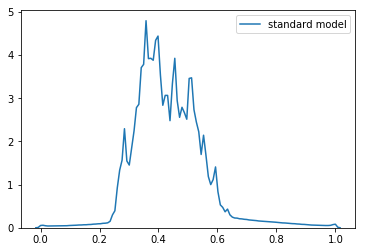

In [16]:
standard_scores = encoder.predict(x_test).ravel()
#regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=False, label='standard model')
#sns.distplot(regularized_scores, hist=False, label='regularized model')

In [17]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs = autoencoder.predict(x_test)


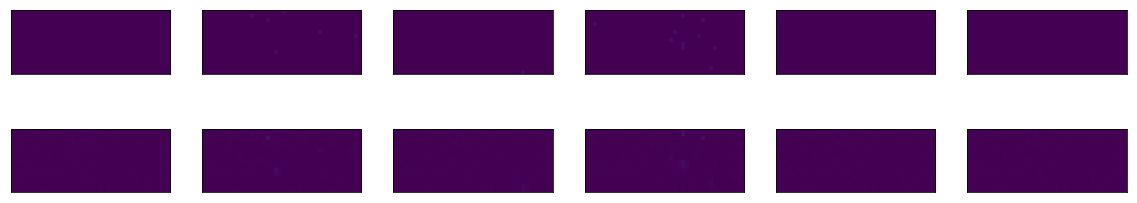

7397


In [18]:
n = 6  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)



In [19]:
import pandas as pd
filename = '../datos_octubre_2018/p_OF_5mm_161mm003.h5'
conjunto_datos_test=pd.read_hdf(filename,'MC');
conjunto_datos_test.shape

(6296, 3840)

In [20]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
L1B=0;
# hay dos L1 con 640 sensores (40*16)
X_trained=conjunto_datos_test.values;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;
x_tested = x_trained;
print(x_trained.shape)
print(x_tested.shape)

(6296, 3840)
(6296, 3840)


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [21]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))

cara_externa=x_tested[:,0: L1A*input_output_dim_A] 
cara_externa_reconstruida=np.zeros((x_tested.shape[0],L1A*input_output_dim_A))
for i in range(x_tested.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_tested[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    salida_reconstructed_1 = autoencoder.predict(ideaA)    
    
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    #entrada_imgs_A=(ideaA) #he quitado el escalado
    #encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    #decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    #salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
 
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))

    #print(hola.shape)
    salida_total=hola1
    #salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

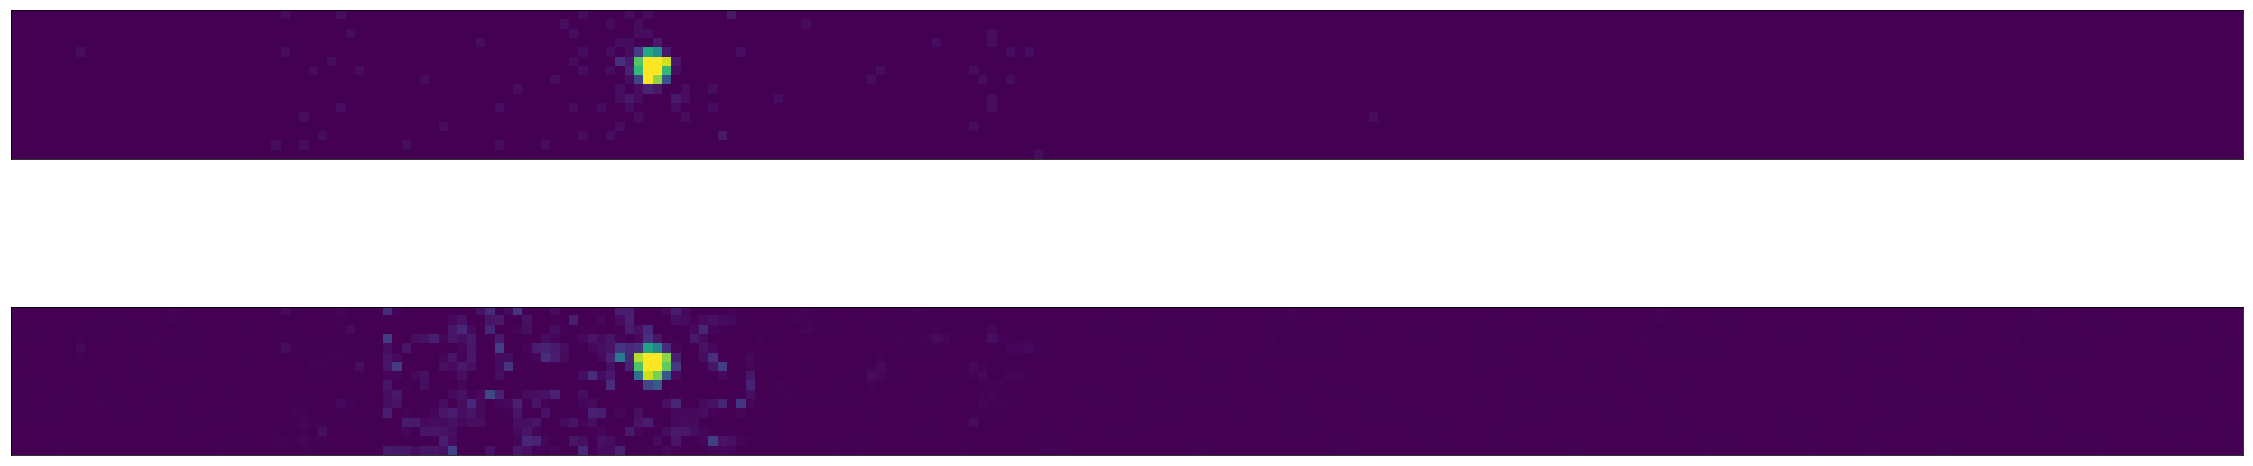

In [22]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_tested.shape[0])
    #idea=1890
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

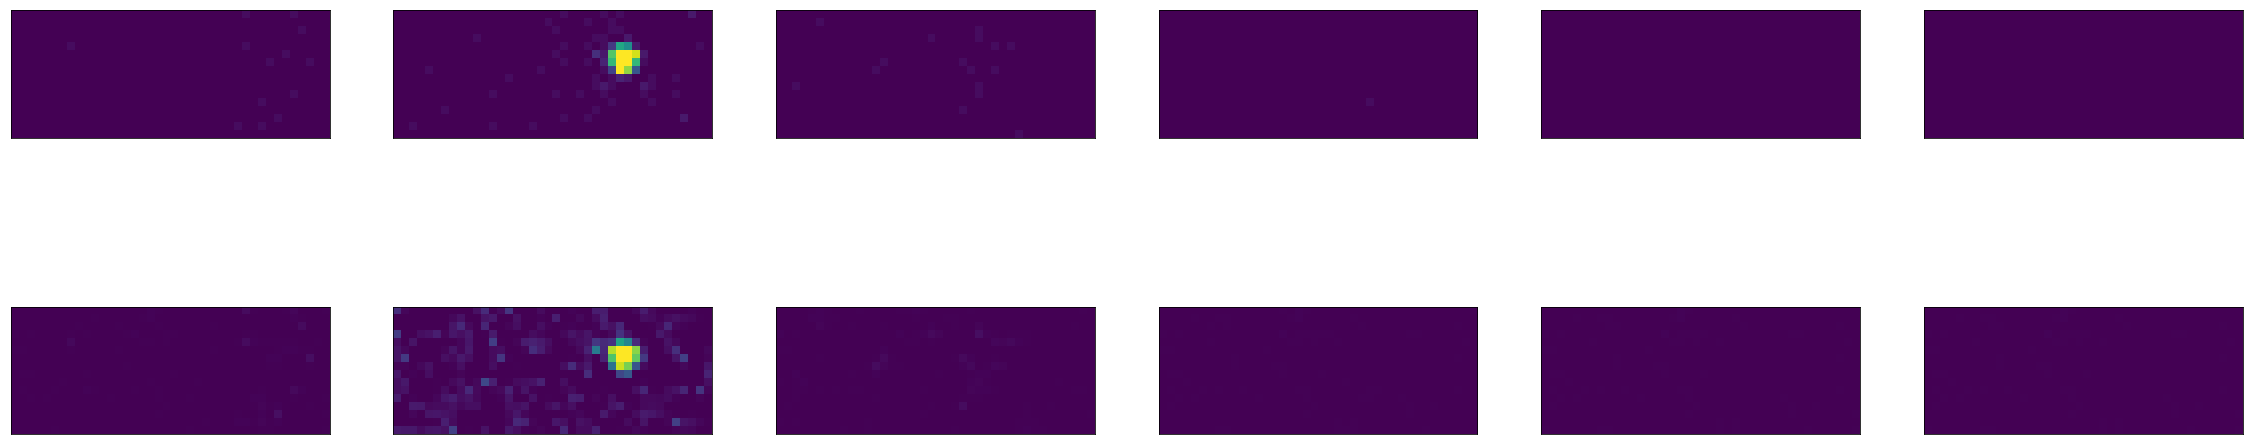

In [23]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
i=1
print(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:])
print(np.sum(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0 

In [28]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:].astype(int))
print(np.sum(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[ 3 -1 -2  5  1  1  1  0  1  1  1  2 -3  0  0  2]
 [ 0 -3 -3  0  0  0  5  0  0  1  1 -2  0  0 -2  1]
 [ 0 -2  0  0  1  0  0 -2  0  0 -1  0  2  0 -1  1]
 [-1 -5 -1  1  0 -2 -3  0  0 -2 -1  0  2 -3 -1  0]
 [-1 -4  0  1  0 -1 -1  1  1  0  0  0  0  1  0  1]
 [-1 -1 -1  2  0  0  0 -2 -1  0  0  0  0  1  0  1]
 [-1 -1  0  0 -2  0  1  0 -1 -3  1  1  0  1  2  1]
 [ 0  0  1  1  0  1  0  0  0  0 -1  2  1  1  0  5]
 [ 0  1  3  1  0  0  1  1  0  1  1  1  0 -1 -1  0]
 [ 0 -1  0  2  1  2  1  0  0  0  3  1  1  0 -1  0]
 [ 1  0 -1  0  0 -1  0  0  0  0  0  0  1  0 -1  0]
 [ 3  1  3  0 -1 -1  0 -1  0  6  0  0  0 -1  0  1]
 [ 0  2 -1  2  5  0  0  1  0  2  0 -1 -2 -2 -2  0]
 [ 0  0  0  0  0  1  4 -1 -1  0  0  0 -1  0 -1  0]
 [ 4  0  0 -1  0  0  0  0 -2  0  2  1  1  0  0  1]
 [ 0  1  1  0  0 -1  0  0  0  0  0 -1  1  1  3  1]
 [-2 -2 -4  0  2  0 -1 -1  0  1  1  0  1  0  2  0]
 [ 0 -1  0  0  2  3  0 -1  0  1  0  1  0  0  0  0]
 [ 0  0  1  0  2  2  0  0  0  2 -2 -2  0 -1  0  0]
 [-1 -1  0 -1  1  0  0 -2 -1  0

In [26]:
print(idea)

5306
